In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

In [3]:
# Check Tensorflow version
tf. __version__

'2.18.0'

In [4]:
(train_raw, val_raw, test_raw), ds_info = tfds.load(name='oxford_iiit_pet',
                                                    split=['train[:90%]',
                                                          'train[90%:]',
                                                          'test'],
                                                    shuffle_files=True,
                                                    as_supervised=True, # Returns (image, label)
                                                    with_info=True # To retrieve dataset info and label names
                                                    )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.40GJGU_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.40GJGU_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [5]:
ds_info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

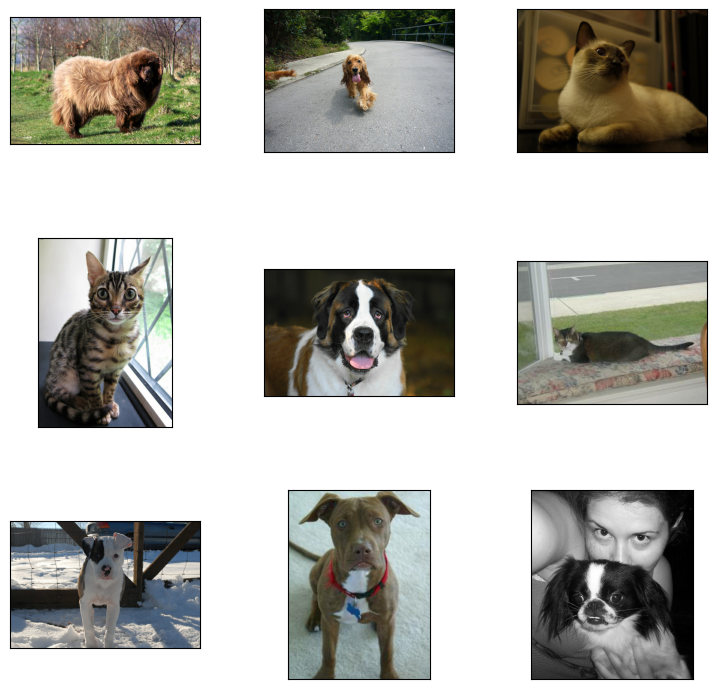

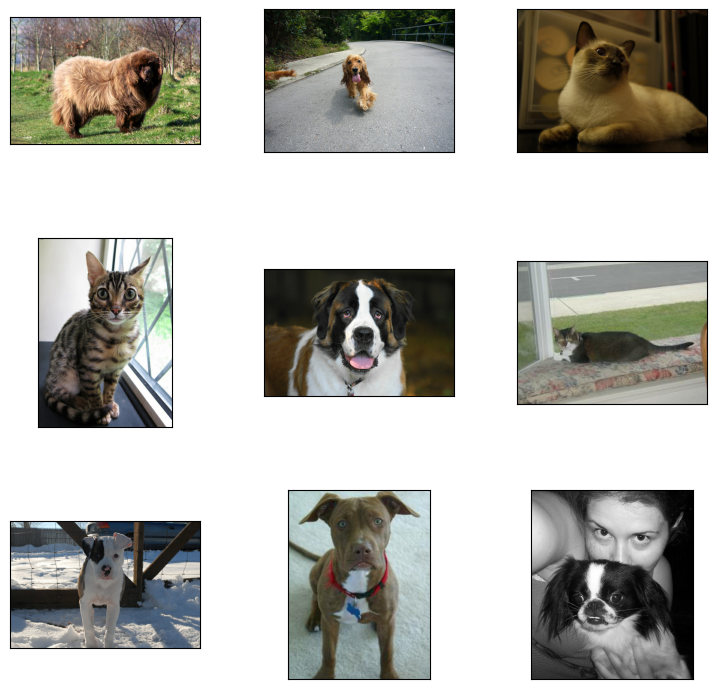

In [6]:
tfds.show_examples(train_raw, ds_info, image_key='image')

In [7]:
# Get number of classes
num_classes = ds_info.features['label'].num_classes
print('Number of classes:', num_classes)

Number of classes: 37


In [8]:
num_train_examples = tf.data.experimental.cardinality(train_raw).numpy()
num_val_examples = tf.data.experimental.cardinality(val_raw).numpy()
num_test_examples = tf.data.experimental.cardinality(test_raw).numpy()

print('Number of training samples:', num_train_examples)
print('Number of validation samples:', num_val_examples)
print('Number of test samples:', num_test_examples)

Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669


In [9]:
def get_value_counts(ds):
    label_list = []
    for images, labels in ds:
        label_list.append(labels.numpy())
    label_counts = pd.Series(label_list).value_counts(sort=True)

    print(label_counts)

In [10]:
get_value_counts(train_raw)

19    96
20    95
26    94
21    94
18    94
23    93
13    93
24    93
14    92
5     92
2     92
35    92
22    91
4     91
31    91
34    90
36    90
10    90
8     90
27    89
3     88
29    88
16    88
30    88
1     88
0     88
9     88
28    87
15    87
12    86
32    86
17    86
25    86
7     85
33    85
6     84
11    82
Name: count, dtype: int64


In [11]:
get_value_counts(val_raw)

6     16
33    15
17    14
25    14
15    13
28    13
32    13
1     12
3     12
30    12
9     12
0     12
16    12
29    12
27    11
11    11
7     11
34    10
8     10
12    10
10    10
36    10
4      9
31     9
5      8
14     8
2      8
35     8
13     7
24     7
23     7
21     6
18     6
26     6
22     5
20     5
19     4
Name: count, dtype: int64


In [12]:
# Function to obtain the name for the label integer
get_label_name = ds_info.features['label'].int2str

In [13]:
# Build the custom function to display image and label name
def view_single_image(ds):
    image, label = next(iter(ds))
    print('Image shape: ', image.shape)
    plt.imshow(image)
    _ = plt.title(get_label_name(label))

Image shape:  (500, 334, 3)


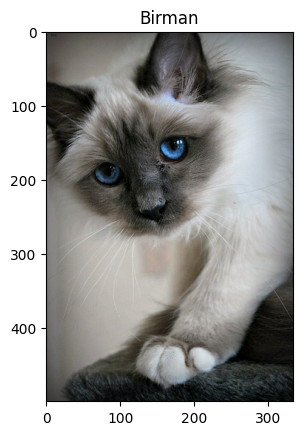

In [14]:
view_single_image(train_raw)

In [15]:
IMG_SIZE = 224

train_ds = train_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
val_ds = val_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
test_ds = test_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))

In [16]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [17]:
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

In [18]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(37,), dtype=tf.float32, name=None))>

In [19]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),
    #  layers.RandomRotation(factor=(-0.025, 0.025)),
    #  layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    #  layers.RandomContrast(factor=0.1),
     ])

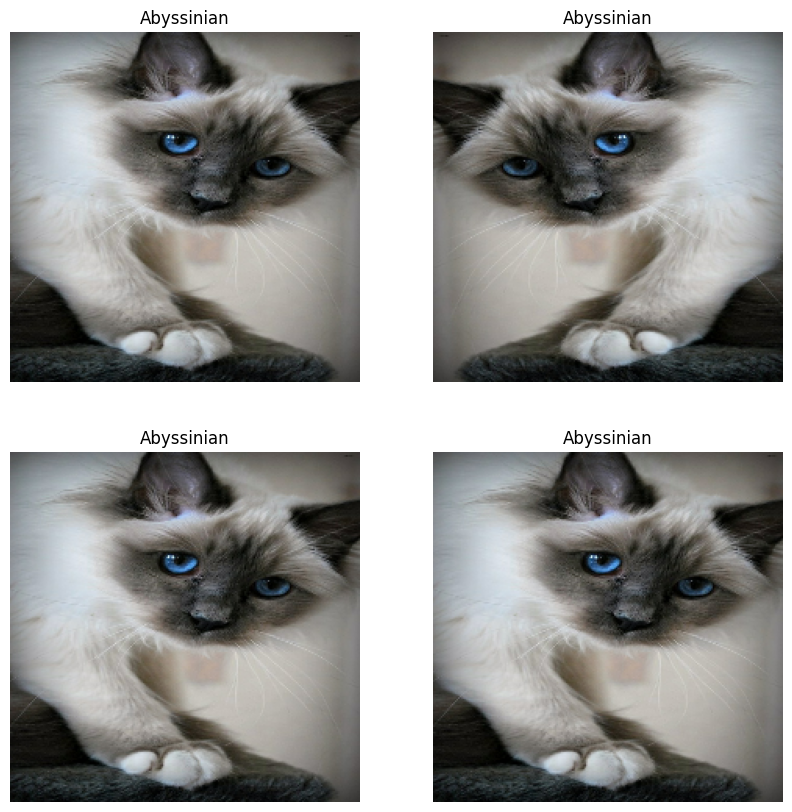

In [20]:
for image, label in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(get_label_name(int(label[0])))
        plt.axis("off")

In [21]:
BATCH_SIZE = 32

In [22]:
# Batch the data and use prefetching to optimize loading speed
# AVOID use of caching (Google Colab RAM limits)

train_ds = train_ds.batch(batch_size=BATCH_SIZE,
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.batch(batch_size=BATCH_SIZE,
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.batch(batch_size=BATCH_SIZE,
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [23]:
base_model = keras.applications.ResNet50V2(
                            include_top=False, # Exclude ImageNet classifier at the top.
                            weights="imagenet",
                            input_shape=(IMG_SIZE, IMG_SIZE, 3)
                            )

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [24]:
# Freeze the base_model
base_model.trainable = False

In [25]:
# Create new model on top
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

In [26]:
x = keras.applications.resnet_v2.preprocess_input(x)

In [27]:
x = base_model(x, training=False)

In [28]:
# Rebuild top layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Regularize with dropout

outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

model = keras.Model(inputs, outputs)

In [29]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 37)             │        75,813 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,648,805 (90.21 MB)

 Trainable params: 79,909 (312.14 KB)

 Non-trainable params: 23,568,896 (89.91 MB)

In [30]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

In [31]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        patience=5,
                                        restore_best_weights=True)

In [32]:
EPOCHS = 25

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1,
                    callbacks =[earlystopping])

Epoch 1/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - categorical_accuracy: 0.4538 - loss: 2.0962 - val_categorical_accuracy: 0.8438 - val_loss: 0.5793
Epoch 2/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - categorical_accuracy: 0.9105 - loss: 0.2815 - val_categorical_accuracy: 0.8693 - val_loss: 0.4524
Epoch 3/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - categorical_accuracy: 0.9427 - loss: 0.1772 - val_categorical_accuracy: 0.8580 - val_loss: 0.4255
Epoch 4/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - categorical_accuracy: 0.9675 - loss: 0.1146 - val_categorical_accuracy: 0.8665 - val_loss: 0.4487
Epoch 5/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - categorical_accuracy: 0.9791 - loss: 0.0787 - val_categorical_accuracy: 0.8665 - val_loss: 0.4366
Epoch 6/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - categorical_accuracy: 0.9913 - loss: 0.0498 - val_categorical_accuracy: 0.8580 - val_loss: 0.4536
Epoch 7/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - categorical_accu

#### Evaluate model on test dataset

In [33]:
result = model.evaluate(test_ds)

114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - categorical_accuracy: 0.8580 - loss: 0.4676


#### Display results

In [34]:
dict(zip(model.metrics_names, result))

{'loss': 0.4499759078025818, 'compile_metrics': 0.8601973652839661}

In [35]:
model.save('my_model.h5')